In [46]:
import networkx as nx
import pandas as pd
import os
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# read edges
topology = open('Sprint/topology.txt', 'r')
lines = topology.readlines()
 
edges = []
# Strips the newline character
for line in lines[1:-1]:
    to_node, from_node, cap, _ = line.split()
    edges.append((int(from_node), int(to_node), int(cap)))

In [48]:
# generate graph
G = nx.Graph() #undirected graph since all edges are bidirectional and have shared capacity
G.add_weighted_edges_from(edges)

{(10, 9): Text(0.6283342729165337, -0.725136406405058, '1000000000'),
 (10, 1): Text(0.8412535328311812, 5.551115123125783e-17, '1000000000'),
 (10, 7): Text(0.093196399442948, -0.6481951959049278, '1000000000'),
 (10, 6): Text(-0.05911972039165814, -0.4111866871485134, '1000000000'),
 (10, 4): Text(0.09319639944294811, 0.10755437844933041, '1000000000'),
 (9, 8): Text(0.1365500873643004, -0.9497267186177256, '1000000000'),
 (9, 4): Text(-0.11972286047169947, -0.07694121050013014, '1000000000'),
 (8, 3): Text(-0.14231483827328512, 5.551115123125783e-17, '1000000000'),
 (8, 7): Text(-0.39858778610928525, -0.8727855081175955, '1000000000'),
 (8, 4): Text(-0.39858778610928514, -0.11703593376333721, '1000000000'),
 (4, 3): Text(-0.398587786109285, 0.8727855081175955, '1000000000'),
 (4, 0): Text(0.1725696330273575, 0.37787478717712913, '1000000000'),
 (4, 5): Text(-0.8071768537798911, 0.5187410655978439, '1000000000'),
 (7, 0): Text(0.1725696330273574, -0.3778747871771291, '1000000000'),
 

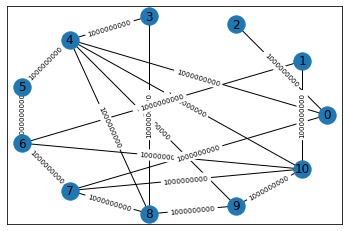

In [49]:
# VISUALIZATION
angles = np.linspace(0, 2*np.pi, 12)[:-1]
coords = [[np.cos(angles[i]), np.sin(angles[i])] for i in range(len(angles))]
pos = {}
for i in range(11):
    pos[i] = coords[i]

nx.draw_networkx(G,pos)
capacities = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=capacities, font_size=7)

In [50]:
# read demands
demand = open('Sprint/demand.txt', 'r')
lines = demand.readlines()
demands = []

for line in lines:
    demands.append(line.split())

demands = np.array(demands, dtype = float)
demands = np.max(demands, axis=0) #use the maximum demand over all times (rows) for each node-node pair

demand = [float(i) for i in line.split()]
n = int(len(demand)**0.5)
demand = np.array(demand).reshape(n, n)
np.fill_diagonal(demand, 0) #demand from a node to itself should be 0

In [51]:
# maximize total throughput
paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("Max Throughput")

edges_vars = {} # maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({tail}, {head})<={capacity}') # gurobipy automatically adds >= 0

demand_vars = {} # maps demand between two nodes to the path variables that constitute it

for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

objective = 0 # accumulate the objective we want to optimize (total flow = sum of path flow variables)

for path in paths:
    p = m.addVar(name=f'{path}')
    objective += p

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

# relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# do not send more than what is demanded
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# Set objective
m.setObjective(objective, GRB.MAXIMIZE)

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 163 rows, 4209 columns and 28227 nonzeros
Model fingerprint: 0x8d94fe43
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+09]
Presolve removed 163 rows and 4209 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7155655e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.715565473e+07
Obj: 1.71557e+07


{(10, 9): 0.0, (10, 1): 0.0, (10, 7): 0.0, (9, 8): 1025165.213203, (9, 4): 0.0, (8, 3): 1500888.705109, (8, 7): 2884676.1910730004, (8, 4): 0.0, (4, 3): 0.0, (4, 0): 0.0, (7, 0): 0.0, (7, 6): 0.0, (0, 2): 3230165.368846, (1, 6): 0.0}
dict_keys([(9, 10), (8, 9), (4, 9), (3, 8), (7, 8), (4, 8), (3, 4), (0, 2), (1, 10), (1, 6), (0, 7), (0, 4), (7, 10), (6, 7)])
dict_keys([(10, 9), (10, 1), (10, 7), (10, 6), (10, 4), (9, 8), (9, 4), (8, 3), (8, 7), (8, 4), (4, 3), (4, 0), (4, 5), (7, 0), (7, 6), (0, 2), (1, 6), (6, 5)])


KeyError: (10, 9)

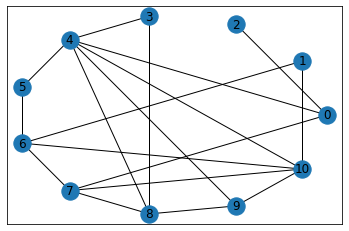

In [52]:
# VISUALIZATION of edge flow by size
# get edge flows
flows = {}
modelVars = m.getVars()
for i in range(len(G.edges())):
    var = modelVars[i]
    edge = eval(var.VarName)
    flows[edge] = var.X
nx.set_edge_attributes(G, flows, "flow")
nx.draw_networkx(G,pos)

print(nx.get_edge_attributes(G,'flow'))

# get edge widths
# widths = []
# for u,v in G.edges():
#     print(u,v)
#     # widths.append(G[u][v]["flow"] / G[u][v]['weight']*1000)

print(flows.keys())
print(capacities.keys())

widths = {}
for edge in G.edges():
    print(flows[edge])
    print(capacities[edge])
    widths[edge] = (flows[edge]/capacities[edge])

nx.draw(G, pos, width=widths)

KeyError: (10, 9)

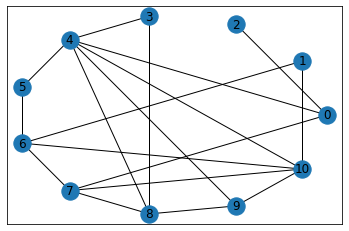

In [ ]:
# visualization with edge flow / capacity
nx.draw_networkx(G,pos)

# get edge widths
labels = dict([(edge, f'{flows[edge]}/{capacities[edge]}')
                    for edge in G.edges])

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=7)

In [53]:
# Minimize the MLU (changing the objective function)

flow = 0 # represents the total flow sent on this network

paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("Min MLU - flow")

# new variable for current MLU
MLU = m.addVar(name="MLU")

edges_vars = {} # maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({src}, {tail})<={head}') # >= 0 is already added
    m.addConstr(edges_vars[(tail, head)][0] / capacity <= MLU)

demand_vars = {} # maps demand between two nodes to the path variables that constitute it

n = len(demand)
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])


for path in paths:
    p = m.addVar(name=f'{path}')
    flow += p # add this path flow to our total flow accumulator

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

# relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# do not send more than what is demanded
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# create a variable for the total flow in the network so we can retrieve its value after solving
total_flow = m.addVar(name="total_flow")
m.addConstr(total_flow == flow)

# Set objective
m.setObjective(MLU - total_flow/np.sum(demands), GRB.MINIMIZE) # minimize MLU but reward satisfying as much demand as possible

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 4211 columns and 32472 nonzeros
Model fingerprint: 0x76926a0b
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [4e-08, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+09]
Presolve removed 55 rows and 19 columns
Presolve time: 0.02s
Presolved: 144 rows, 4192 columns, 28225 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.178e+03
 Factor NZ  : 3.090e+03 (roughly 2 MB of memory)
 Factor Ops : 7.795e+04 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.05 seconds (0.01 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dua

In [54]:
print("MLU: ", MLU.X)
print("Total flow: ", total_flow.X)

MLU:  0.014255519239266008
Total flow:  17155654.725871008


In [55]:
# Minimize MLU (adding a constraint)

flow = 0 # represents the total flow sent on this network

paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("Min MLU with constraint")

# new variable for MLU
MLU = m.addVar(name="MLU")

edges_vars = {} #maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({src}, {tail})<={head}') # >= 0 is already added
    m.addConstr(edges_vars[(tail, head)][0] / capacity <= MLU)

demand_vars = {} # maps demand between two nodes to the path variables that constitute it

n = len(demand)
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

for path in paths:
    p = m.addVar(name=f'{path}')
    flow += p # add this path flow to our total flow accumulator

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

#relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# do not send more than what is demanded
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) >= demand_vars[key][0])

# create a variable for the total flow in the network so we can retrieve its value after solving
total_flow = m.addVar(name="total_flow")
m.addConstr(total_flow == flow)

# Set objective
m.setObjective(MLU, GRB.MINIMIZE)

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 4211 columns and 32472 nonzeros
Model fingerprint: 0xe3fc690c
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+09]
Presolve removed 55 rows and 20 columns
Presolve time: 0.02s
Presolved: 144 rows, 4191 columns, 28224 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.178e+03
 Factor NZ  : 3.090e+03 (roughly 2 MB of memory)
 Factor Ops : 7.795e+04 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.04 seconds (0.01 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dua

In [56]:
print("MLU: ", m.ObjVal)
print("Total flow: ", total_flow.X)

MLU:  0.0044902379695640005
Total flow:  17155654.725871008
